In [1]:
import network
import torch
from PIL import Image
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import cv2
import utils
from datasets.acdc import ACDCDataset
import os
from torch.utils.data import DataLoader, Dataset
from utils.ext_transforms import *
from utils.utils import Denormalize, denormalize
from pathlib import Path

MODEL_NAME = 'deeplabv3plus_resnet101'
NUM_CLASSES = 19
OUTPUT_STRIDE = 16
TARGET_RESOLUTION = (768, 768)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

denorm = Denormalize(MEAN, STD)

In [44]:
model = network.modeling.__dict__[MODEL_NAME](num_classes=NUM_CLASSES, output_stride=OUTPUT_STRIDE)
model.load_state_dict(torch.load('/media/talmacsi/48a93eb4-f27d-48ec-9f74-64e475c3b6ff/Downloads/best_deeplabv3plus_resnet101_cityscapes_os16.pth.tar')['model_state'])

model.to('cuda')
model = model.eval()

decode_fn = ACDCDataset.decode_target
utils.set_bn_momentum(model.backbone, momentum=0.01)

In [4]:
data_root = Path('/media/talmacsi/48a93eb4-f27d-48ec-9f74-64e475c3b6ff/Downloads/data')
rgb_anon_path = data_root / 'rgb_anon'
gt_path = data_root / 'gt'

In [15]:
transform = ExtCompose([
    ExtRandomHorizontalFlip(p=0.5),
    ExtResize(size=(1080//4,1920//4), interpolation=Image.BILINEAR),
    ExtRandomCrop(size=(256,256)),
    ExtColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    #AddGaussianNoise(mean=0.1, std_range=(0.0, 0.05)),
    ClassWiseMasking(p=0.1, num_classes_to_keep=1),  # Replace with your class IDs
    ExtToTensor(),
    ExtNormalize(mean=MEAN, std=STD),
])

val_transform = ExtCompose([
    ExtResize(size=(1080//4,1920//4), interpolation=Image.BILINEAR),
    ExtCenterCrop(size=(128,128)),
    ExtToTensor(),
    ExtNormalize(mean=MEAN, std=STD),
])

# Load your image
img_path = str(rgb_anon_path / 'fog/train/GOPR0475/GOPR0475_frame_000041_rgb_anon.png')
gt_label_ids_path = str(gt_path / 'fog/train/GOPR0475/GOPR0475_frame_000041_gt_labelIds.png')
gt_color_path = str(gt_path / 'fog/train/GOPR0475/GOPR0475_frame_000041_gt_labelColor.png')
img = Image.open(img_path).convert("RGB")
label = Image.open(gt_label_ids_path)

In [5]:
img.size

(1920, 1080)

In [17]:
trans_img, trans_label = transform(img, label)
print(type(trans_img), type(trans_label))
print(np.unique(trans_label))

decoded_label = ACDCDataset.encode_target(trans_label)
print(type(decoded_label))
decoded_label = torch.from_numpy(np.array(decoded_label)).long()
print(type(decoded_label))

print(np.unique(decoded_label))

<class 'torch.Tensor'> <class 'torch.Tensor'>
[ 0  7  8 11 12 13 17 19 20 21 22 23 24 26 27]
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
[  0   1   2   3   4   5   6   7   8   9  10  11  13  14 255]


In [8]:
# def unnormalize(tensor):
#     mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(tensor.device)
#     std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(tensor.device)
#     return tensor*std + mean



def visualize_masking(dataset, index):
    image, label = dataset[index]
    image = image.detach().cpu().numpy()
    # Convert tensors to numpy arrays
    image_np = (denorm(image) * 255).transpose(1, 2, 0).astype(np.uint8)  # From C x H x W to H x W x C
    #image_np = denormalize(image_np, mean=MEAN, std=STD).permute(1, 2, 0).numpy()
    label_np = label.numpy()
    print(np.unique(label_np))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title('Masked Image')
    plt.subplot(1, 2, 2)
    plt.imshow(label_np, cmap='gray')
    plt.title('Label')
    plt.show()


# Create the dataset
dataset = ACDCDataset(
    root_dir=data_root,
    split='train',
    weather=['fog', 'rain'],
    transform=transform
)

# print(dataset.__len__())

# visualize_masking(dataset, 2)

torch.Size([1, 3, 256, 256]) torch.Size([256, 256])


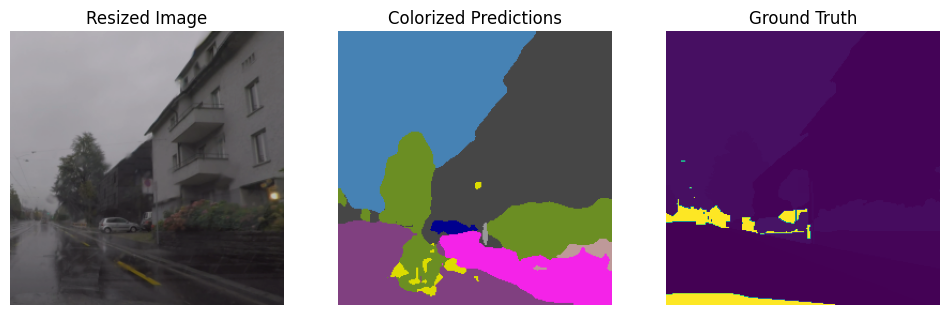

In [301]:
input_tensor, lbl_tensor = dataset[54]

#input_tensor, lbl_tensor = transform(img, label) # To tensor of NCHW
input_tensor = input_tensor.unsqueeze(0).to('cuda')
print(input_tensor.shape, lbl_tensor.shape)
# input_tensor = input_tensor.to('cuda')
# input_tensor.requires_grad = True

# #with torch.no_grad():
output = model(input_tensor)
pred = output.max(1)[1].cpu().numpy()[0] 

colorized_preds = decode_fn(pred).astype('uint8')
colorized_preds = Image.fromarray(colorized_preds)

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
image = input_tensor.detach().cpu().numpy()
# Convert tensors to numpy arrays
image_np = (denorm(image.squeeze(0)) * 255).transpose(1, 2, 0).astype(np.uint8)  # From C x H x W to H x W x C
lbl_tensor = lbl_tensor.numpy()
# Display resized_img
axes[0].imshow(image_np)
axes[0].set_title('Resized Image')
axes[0].axis('off')

# Display colorized_preds
axes[1].imshow(colorized_preds)
axes[1].set_title('Colorized Predictions')
axes[1].axis('off')

# Display colorized_preds
axes[2].imshow(lbl_tensor)
axes[2].set_title('Ground Truth')
axes[2].axis('off')

plt.show()

# inference

In [2]:
model = network.modeling.__dict__[MODEL_NAME](num_classes=NUM_CLASSES, output_stride=OUTPUT_STRIDE)
model.load_state_dict(torch.load('/home/talmacsi/Documents/BME/WeatherConverter/seg_model/outputs/checkpoints/deeplabv3plus_resnet101_epoch_20.pth')['model_state_dict'])

model.to('cuda')
model = model.eval()

decode_fn = ACDCDataset.decode_target
#utils.set_bn_momentum(model.backbone, momentum=0.01)

In [18]:
val_dataset = ACDCDataset(
    root_dir=data_root,
    split='train',
    weather=['fog', 'rain'],
    transform=val_transform
)

torch.Size([1, 3, 128, 128]) torch.Size([128, 128])


(-0.5, 127.5, 127.5, -0.5)

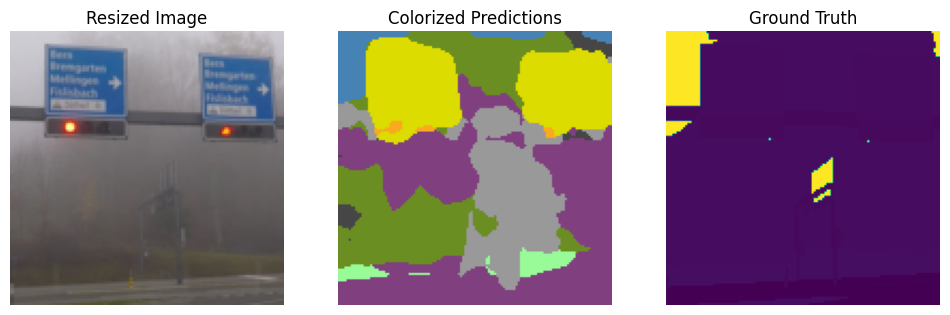

In [22]:
input_tensor, lbl_tensor = val_dataset[65]

#input_tensor, lbl_tensor = transform(img, label) # To tensor of NCHW
input_tensor = input_tensor.unsqueeze(0).to('cuda')
print(input_tensor.shape, lbl_tensor.shape)
# input_tensor = input_tensor.to('cuda')
# input_tensor.requires_grad = True

# #with torch.no_grad():
output = model(input_tensor)
pred = output.max(1)[1].cpu().numpy()[0] 

colorized_preds = decode_fn(pred).astype('uint8')
colorized_preds = Image.fromarray(colorized_preds)

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
image = input_tensor.detach().cpu().numpy()
# Convert tensors to numpy arrays
image_np = (denorm(image.squeeze(0)) * 255).transpose(1, 2, 0).astype(np.uint8)  # From C x H x W to H x W x C
lbl_tensor = lbl_tensor.numpy()
# Display resized_img
axes[0].imshow(image_np)
axes[0].set_title('Resized Image')
axes[0].axis('off')

# Display colorized_preds
axes[1].imshow(colorized_preds)
axes[1].set_title('Colorized Predictions')
axes[1].axis('off')

# Display colorized_preds
axes[2].imshow(lbl_tensor)
axes[2].set_title('Ground Truth')
axes[2].axis('off')


# Try with super res image

In [8]:
val_transform = ExtCompose([
    ExtResize(size=(1080//2,1920//2), interpolation=Image.BILINEAR, just_label=True),
    ExtCenterCrop(size=(512,512), just_label=True),
    ExtToTensor(),
    ExtNormalize(mean=MEAN, std=STD),
])

val_color_transform = T.Compose([
    T.Resize(size=(1080//2,1920//2), interpolation=Image.BILINEAR),
    T.CenterCrop(size=(512,512))
])

# Load your image
img_path = '/home/talmacsi/Documents/BME/WeatherConverter/Swift-SRGAN/swift-srgan/image_super_resolved.png'
gt_label_ids_path = str(gt_path / 'fog/val/GOPR0476/GOPR0476_frame_000854_gt_labelIds.png')
gt_color_path = str(gt_path / 'fog/val/GOPR0476/GOPR0476_frame_000854_gt_labelColor.png')
img = Image.open(img_path).convert("RGB")
label = Image.open(gt_label_ids_path)
lable_colored = Image.open(gt_color_path)

In [15]:
# Apply transformations
input_tensor, lbl_tensor = val_transform(img, label)      
lbl_colored_img = val_color_transform(lable_colored)  
print(type(input_tensor), type(lbl_tensor), type(lbl_colored_img))
# Prepare tensors for the model
input_tensor = input_tensor.unsqueeze(0).to('cuda')  

print(f"Unique values in label tensor: {torch.unique(lbl_tensor)}")

decoded_label = ACDCDataset.encode_target(lbl_tensor)
decoded_label = torch.from_numpy(np.array(decoded_label)).unsqueeze(0).long().to('cuda')
print(f"Unique values in label tensor: {torch.unique(decoded_label)}")

print(f"Input Tensor Shape: {input_tensor.shape}")    
print(f"Label Tensor Shape: {decoded_label.shape}")      
print(f"Label Image Shape: {lbl_colored_img.size}")      


<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'PIL.Image.Image'>
Unique values in label tensor: tensor([ 0,  7,  8, 11, 12, 17, 20, 21, 22, 23, 26], dtype=torch.uint8)
Unique values in label tensor: tensor([  0,   1,   2,   3,   5,   7,   8,   9,  10,  13, 255],
       device='cuda:0')
Input Tensor Shape: torch.Size([1, 3, 512, 512])
Label Tensor Shape: torch.Size([1, 512, 512])
Label Image Shape: (512, 512)


In [16]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

model.eval()
for param in model.parameters():
    param.requires_grad = False

# Zero gradients
model.zero_grad()
if input_tensor.grad is not None:
    input_tensor.grad.zero_()

# Enable gradient tracking on the input tensor
input_tensor.requires_grad = True

print(f"Input Tensor requires gradient: {input_tensor.requires_grad}")
print(f"Input tensor gradient: {input_tensor.grad}")


# Perform inference
output = model(input_tensor)                # Output shape: [1, num_classes, 512, 512]
print(f"Output tensor shape: {output.shape}")
pred = output.argmax(dim=1).squeeze(0).cpu().numpy()  # Shape: [512, 512]

loss = criterion(output, decoded_label.squeeze(1).long().cuda())

loss.backward()

input_gradients = input_tensor.grad  # Shape: [1, 3, 512, 512]

Input Tensor requires gradient: True
Input tensor gradient: None
Output tensor shape: torch.Size([1, 19, 512, 512])


Gradient min: 4.8399584e-06
Gradient max: 0.023124242


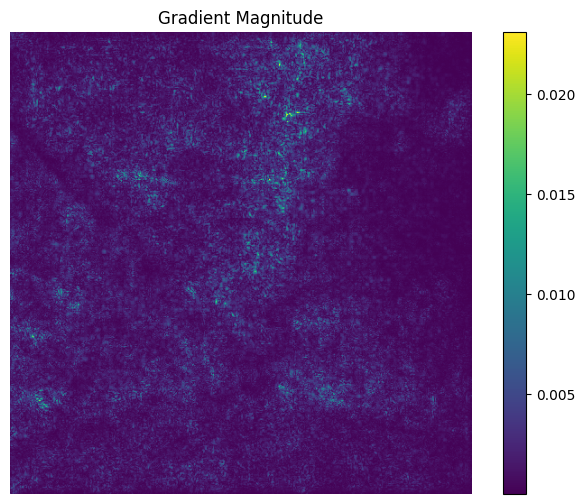

In [18]:
# Convert gradients to numpy array
gradients_np = input_gradients.detach().cpu().squeeze(0).numpy()  # Shape: [3, 512, 512]

# Multiply by the standard deviation
#gradients_np = gradients_np * np.array(STD)[:, None, None]

# Compute gradient magnitude
gradient_magnitude = np.sqrt(np.sum(gradients_np ** 2, axis=0))  # Shape: [512, 512]

print("Gradient min:", gradient_magnitude.min())
print("Gradient max:", gradient_magnitude.max())

# Normalize gradient magnitude to [0,1] for better visualization
gradient_magnitude_norm = (gradient_magnitude - gradient_magnitude.min()) / (gradient_magnitude.max() - gradient_magnitude.min())

# Plotting the gradient magnitude
plt.figure(figsize=(8, 6))
plt.imshow(gradient_magnitude, cmap='viridis')
plt.title('Gradient Magnitude')
plt.colorbar()
plt.axis('off')
plt.show()

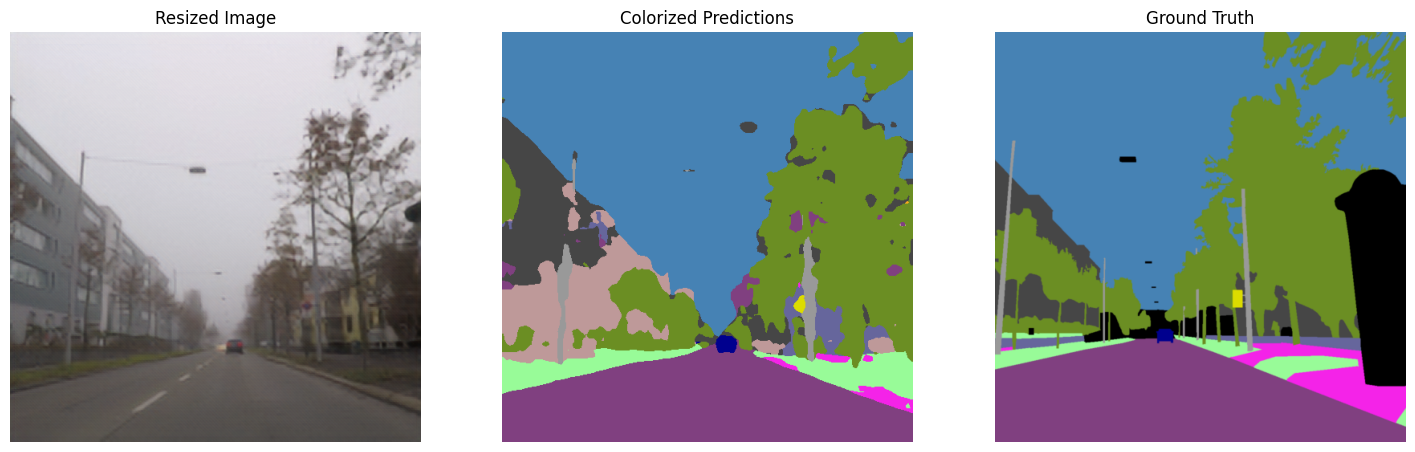

In [19]:
colorized_preds = decode_fn(pred).astype('uint8')
colorized_preds = Image.fromarray(colorized_preds)

# Convert input tensor to numpy array for visualization
image_np = denorm(input_tensor.squeeze(0).detach().cpu()).numpy()
image_np = np.transpose(image_np, (1, 2, 0))  # From [C, H, W] to [H, W, C]
image_np = np.clip(image_np, 0, 1) * 255
image_np = image_np.astype(np.uint8)

# Plotting the input image, predictions, and ground truth
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

# Display input image
axes[0].imshow(image_np)
axes[0].set_title('Resized Image')
axes[0].axis('off')

# Display colorized predictions
axes[1].imshow(colorized_preds)
axes[1].set_title('Colorized Predictions')
axes[1].axis('off')

# Display gradients
axes[2].imshow(gradient_magnitude_norm, cmap='viridis')
axes[2].set_title('Gradients')
axes[2].axis('off')

# Display ground truth labels
axes[3].imshow(lbl_colored_img, cmap='gray')
axes[3].set_title('Ground Truth')
axes[3].axis('off')

plt.show()

In [14]:


# Resize label tensor to match output size (if necessary)
decoded_label = decoded_label.unsqueeze(0).long().cuda()  # Shape: [1, H_out, W_out]

print(f"Unique Labels in Resized Label Tensor: {torch.unique(decoded_label)}")
print(f"Resized Label Tensor Shape: {decoded_label.shape}")  # Expected: [1, 512, 512]

# Define the loss function
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)



# Compute loss
loss = criterion(output, decoded_label)

# Backward pass
loss.backward()

# Access gradients w.r.t. input
input_gradients = input_tensor.grad  # Shape: [1, 3, 512, 512]

# Convert gradients to numpy array
gradients_np = input_gradients.detach().cpu().squeeze(0).numpy()  # Shape: [3, 512, 512]

# Multiply by the standard deviation
gradients_np = gradients_np * np.array(STD)[:, None, None]

# Compute gradient magnitude
gradient_magnitude = np.sqrt(np.sum(gradients_np ** 2, axis=0))  # Shape: [512, 512]

print("Gradient min:", gradient_magnitude.min())
print("Gradient max:", gradient_magnitude.max())

# Normalize gradient magnitude to [0,1] for better visualization
gradient_magnitude_norm = (gradient_magnitude - gradient_magnitude.min()) / (gradient_magnitude.max() - gradient_magnitude.min())

# Plotting the gradient magnitude
plt.figure(figsize=(8, 6))
plt.imshow(gradient_magnitude_norm, cmap='viridis')
plt.title('Gradient Magnitude')
plt.colorbar()
plt.axis('off')
plt.show()


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

torch.Size([1, 3, 512, 512]) torch.Size([1, 512, 512])


(-0.5, 511.5, 511.5, -0.5)

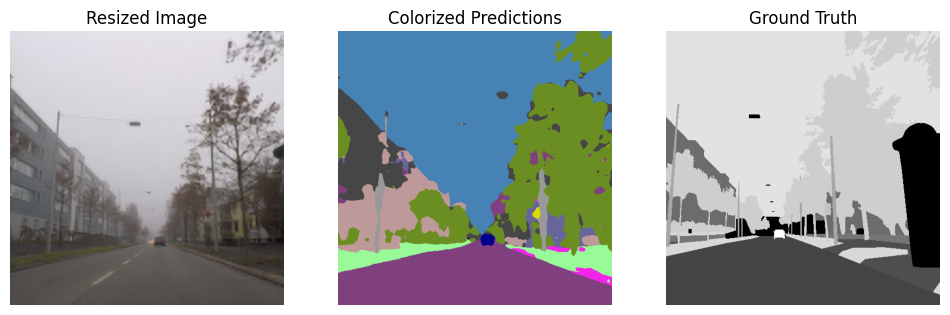

In [56]:
input_tensor, lbl_tensor = val_image_transform(img), val_label_transform(label)

#input_tensor, lbl_tensor = transform(img, label) # To tensor of NCHW
input_tensor = input_tensor.unsqueeze(0).to('cuda')
print(input_tensor.shape, lbl_tensor.shape)

input_tensor = input_tensor.to('cuda')
input_tensor.requires_grad = True

# #with torch.no_grad():
model.train()
output = model(input_tensor)
pred = output.max(1)[1].cpu().numpy()[0] 

colorized_preds = decode_fn(pred).astype('uint8')
colorized_preds = Image.fromarray(colorized_preds)

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
image = input_tensor.detach().cpu().numpy()
# Convert tensors to numpy arrays
image_np = (denorm(image.squeeze(0)) * 255).transpose(1, 2, 0).astype(np.uint8)  # From C x H x W to H x W x C
lbl_display = lbl_tensor.squeeze(0).numpy()
# Display resized_img
axes[0].imshow(image_np)
axes[0].set_title('Resized Image')
axes[0].axis('off')

# Display colorized_preds
axes[1].imshow(colorized_preds)
axes[1].set_title('Colorized Predictions')
axes[1].axis('off')

# Display colorized_preds
axes[2].imshow(lbl_display, cmap='gray')
axes[2].set_title('Ground Truth')
axes[2].axis('off')


In [47]:
import torch.nn.functional as F

# Resize label tensor to match output size
output_size = output.shape[2:]  # (H_out, W_out)
label_tensor_resized = F.interpolate(
    lbl_tensor.unsqueeze(1).float(),
    size=output_size,
    mode='nearest'
).squeeze(1).long().cuda()

print(label_tensor_resized.shape)

torch.Size([1, 512, 512])


In [57]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

# Zero gradients
model.zero_grad()
input_tensor.grad = None  # Clear existing gradients on the input tensor

# Compute loss
loss = criterion(output, lbl_tensor.squeeze(1).long().cuda())

# Backward pass
loss.backward()

# Access gradients w.r.t. input
input_gradients = input_tensor.grad  # Shape: (N, C, H, W)

In [58]:
input_gradients.shape

torch.Size([1, 3, 512, 512])

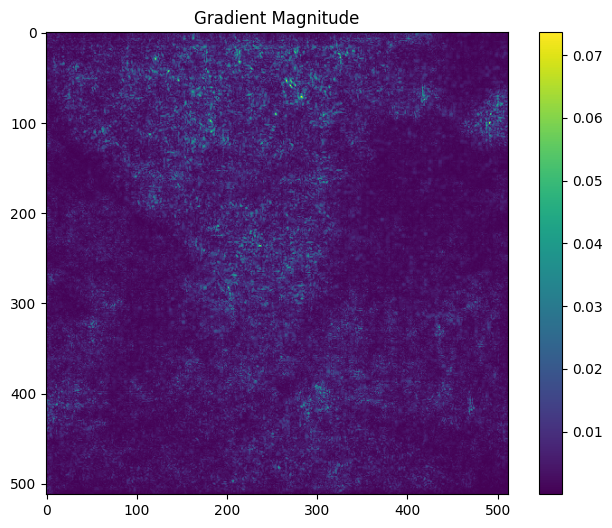

In [59]:
# Visualize gradients
gradients_np = input_gradients.detach().cpu().squeeze(0).numpy()  # Shape: (3, H, W)
gradient_magnitude = np.sqrt(np.sum(gradients_np ** 2, axis=0))  # Shape: (H, W)

plt.figure(figsize=(8, 6))
plt.imshow(gradient_magnitude, cmap='viridis')
plt.title('Gradient Magnitude')
plt.colorbar()
plt.show()


In [7]:
np.unique(pred)

array([ 0,  1,  2,  4,  5,  7,  8,  9, 10, 11, 13])

In [8]:
gt_color_path = '/home/coffeecola/BME/WeatherConverter/data/gt/fog/train/GOPR0475/GOPR0475_frame_000041_gt_labelColor.png'
gt_grey_path = '/home/coffeecola/BME/WeatherConverter/data/gt/fog/train/GOPR0475/GOPR0475_frame_000041_gt_invGray.png'
gt_ids_path = '/home/coffeecola/BME/WeatherConverter/data/gt/fog/train/GOPR0475/GOPR0475_frame_000041_gt_invIds.png'
gt_label_ids_path = '/home/coffeecola/BME/WeatherConverter/data/gt/fog/train/GOPR0475/GOPR0475_frame_000041_gt_labelIds.png'

label_array = np.array(Image.open(gt_label_ids_path))
np.unique(label_array)

array([ 0,  7,  8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 26, 27],
      dtype=uint8)

In [9]:
from labels import labels

# Define ignore index
ignore_index = 255

# Create the mapping
id_to_trainId = {label.id: label.trainId if not label.ignoreInEval else ignore_index for label in labels}

In [10]:
# Apply the mapping to the label array
def map_label(label_array, id_to_trainId):
    mapped_label_array = label_array.copy()
    for id_value, trainId_value in id_to_trainId.items():
        mapped_label_array[label_array == id_value] = trainId_value
    return mapped_label_array


mapped_label_array = map_label(label_array, id_to_trainId)


In [11]:
label_tensor = torch.from_numpy(mapped_label_array).long()  # Shape: (H, W)
label_tensor = label_tensor.unsqueeze(0).to('cuda')  # Add batch dimension

unique_mapped_labels = torch.unique(label_tensor)
print("Unique labels after mapping:", unique_mapped_labels)

Unique labels after mapping: tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,  14,
        255], device='cuda:0')


In [12]:
label_tensor.shape

torch.Size([1, 1080, 1920])

In [13]:
import torch.nn.functional as F

# Resize label tensor to match output size
output_size = output.shape[2:]  # (H_out, W_out)
label_tensor_resized = F.interpolate(
    label_tensor.unsqueeze(1).float(),
    size=output_size,
    mode='nearest'
).squeeze(1).long()

In [14]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=ignore_index)

# Zero gradients
model.zero_grad()
input_tensor.grad = None  # Clear existing gradients on the input tensor

# Compute loss
loss = criterion(output, label_tensor_resized)

# Backward pass
loss.backward()

# Access gradients w.r.t. input
input_gradients = input_tensor.grad  # Shape: (N, C, H, W)

In [9]:
def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(tensor.device)
    return tensor*std + mean

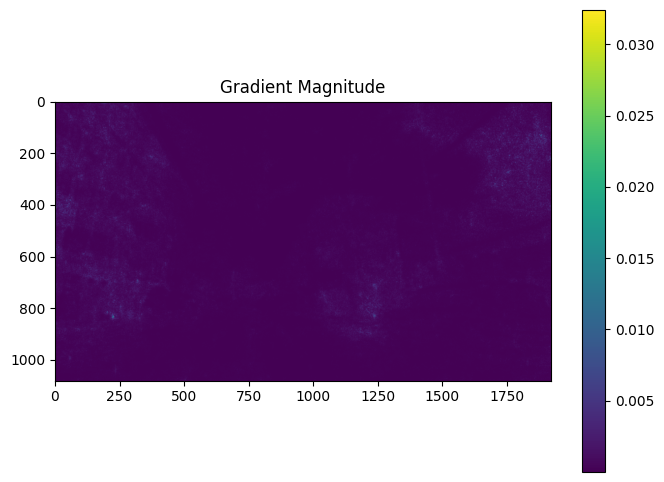

In [16]:
# Visualize gradients
gradients_np = input_gradients.detach().cpu().squeeze(0).numpy()  # Shape: (3, H, W)
gradient_magnitude = np.sqrt(np.sum(gradients_np ** 2, axis=0))  # Shape: (H, W)

plt.figure(figsize=(8, 6))
plt.imshow(gradient_magnitude, cmap='viridis')
plt.title('Gradient Magnitude')
plt.colorbar()
plt.show()


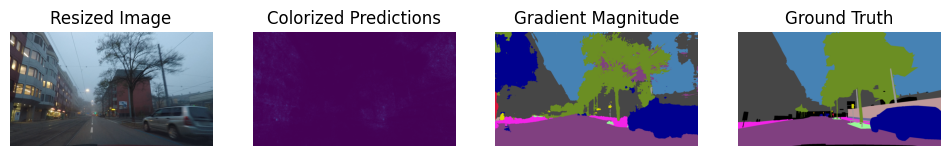

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6))

# Display resized_img
axes[0].imshow(img)
axes[0].set_title('Resized Image')
axes[0].axis('off')

# Display colorized_preds
axes[1].imshow(gradient_magnitude)
axes[1].set_title('Colorized Predictions')
axes[1].axis('off')

# Display gradient_magnitude
axes[2].imshow(colorized_preds, cmap='viridis')
axes[2].set_title('Gradient Magnitude')
axes[2].axis('off')

label = np.array(Image.open(gt_color_path))
axes[3].imshow(label)
axes[3].set_title('Ground Truth')
axes[3].axis('off')
plt.show()

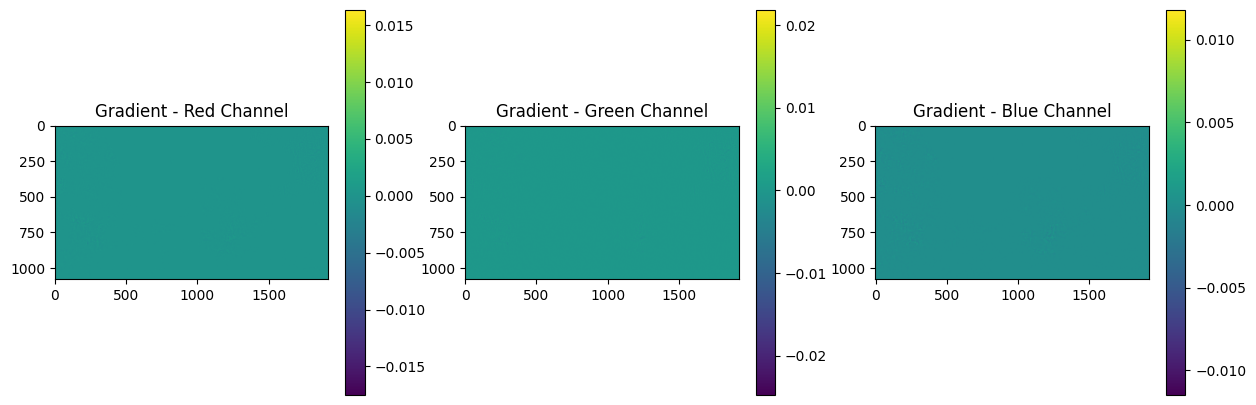

In [18]:
channels = ['Red', 'Green', 'Blue']
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(gradients_np[i], cmap='viridis')
    plt.title(f'Gradient - {channels[i]} Channel')
    plt.colorbar()
plt.show()

In [39]:
TARGET_RESOLUTION = (540//2, 960//2)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [40]:
from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image
import torch
from typing import Callable, Union, Optional
from collections import namedtuple
class ACDCDataset(Dataset):
    
    CityscapesClass = namedtuple('CityscapesClass', ['name', 'id', 'train_id', 'category', 'category_id',
                                                        'has_instances', 'ignore_in_eval', 'color'])
    classes = [
        CityscapesClass('unlabeled',            0, 255, 'void', 0, False, True, (0, 0, 0)),
        CityscapesClass('ego vehicle',          1, 255, 'void', 0, False, True, (0, 0, 0)),
        CityscapesClass('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
        CityscapesClass('out of roi',           3, 255, 'void', 0, False, True, (0, 0, 0)),
        CityscapesClass('static',               4, 255, 'void', 0, False, True, (0, 0, 0)),
        CityscapesClass('dynamic',              5, 255, 'void', 0, False, True, (111, 74, 0)),
        CityscapesClass('ground',               6, 255, 'void', 0, False, True, (81, 0, 81)),
        CityscapesClass('road',                 7, 0, 'flat', 1, False, False, (128, 64, 128)),
        CityscapesClass('sidewalk',             8, 1, 'flat', 1, False, False, (244, 35, 232)),
        CityscapesClass('parking',              9, 255, 'flat', 1, False, True, (250, 170, 160)),
        CityscapesClass('rail track',           10, 255, 'flat', 1, False, True, (230, 150, 140)),
        CityscapesClass('building',             11, 2, 'construction', 2, False, False, (70, 70, 70)),
        CityscapesClass('wall',                 12, 3, 'construction', 2, False, False, (102, 102, 156)),
        CityscapesClass('fence',                13, 4, 'construction', 2, False, False, (190, 153, 153)),
        CityscapesClass('guard rail',           14, 255, 'construction', 2, False, True, (180, 165, 180)),
        CityscapesClass('bridge',               15, 255, 'construction', 2, False, True, (150, 100, 100)),
        CityscapesClass('tunnel',               16, 255, 'construction', 2, False, True, (150, 120, 90)),
        CityscapesClass('pole',                 17, 5, 'object', 3, False, False, (153, 153, 153)),
        CityscapesClass('polegroup',            18, 255, 'object', 3, False, True, (153, 153, 153)),
        CityscapesClass('traffic light',        19, 6, 'object', 3, False, False, (250, 170, 30)),
        CityscapesClass('traffic sign',         20, 7, 'object', 3, False, False, (220, 220, 0)),
        CityscapesClass('vegetation',           21, 8, 'nature', 4, False, False, (107, 142, 35)),
        CityscapesClass('terrain',              22, 9, 'nature', 4, False, False, (152, 251, 152)),
        CityscapesClass('sky',                  23, 10, 'sky', 5, False, False, (70, 130, 180)),
        CityscapesClass('person',               24, 11, 'human', 6, True, False, (220, 20, 60)),
        CityscapesClass('rider',                25, 12, 'human', 6, True, False, (255, 0, 0)),
        CityscapesClass('car',                  26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
        CityscapesClass('truck',                27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
        CityscapesClass('bus',                  28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
        CityscapesClass('caravan',              29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
        CityscapesClass('trailer',              30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
        CityscapesClass('train',                31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
        CityscapesClass('motorcycle',           32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
        CityscapesClass('bicycle',              33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
        CityscapesClass('license plate',        -1, 255, 'vehicle', 7, False, True, (0, 0, 142)),
    ]

    train_id_to_color = [c.color for c in classes if (c.train_id != -1 and c.train_id != 255)]
    train_id_to_color.append([0, 0, 0])
    train_id_to_color = np.array(train_id_to_color)
    id_to_train_id = np.array([c.train_id for c in classes])


    def __init__(self, root_dir: str, split: str='train', weather: Union[str, list[str]]='all', transform: Optional[Callable[[Image.Image], torch.Tensor]]=None, target_transform: Optional[Callable[[Image.Image], torch.Tensor]]=None):
        """
        Args:
            root_dir (str or Path): Root directory of the dataset (parent of 'gt' and 'rgb_anon' folders).
            split (str): One of 'train', 'val', 'test', etc.
            weather (str): One of 'fog', 'night', 'rain', 'snow', or 'all' to include all conditions.
            transform (callable, optional): Optional transform to be applied on an image.
            target_transform (callable, optional): Optional transform to be applied on a label.
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.weather = weather
        self.transform = transform
        self.target_transform = target_transform
        
        self.image_paths = []
        self.label_paths = []

        if weather == 'all':
            weather_conditions = ['fog', 'night', 'rain', 'snow']
        #elif all(item in ['fog', 'night', 'rain', 'snow'] for item in weather):
        else:
            weather_conditions = weather

        for condition in weather_conditions:
            rgb_dir = self.root_dir / 'rgb_anon' / condition / split
            gt_dir = self.root_dir / 'gt' / condition / split

            # For each image in rgb_dir, find the corresponding label in gt_dir
            image_pattern = '**/*_rgb_anon.*'  # Matches files ending with '_rgb_anon.png' or '_rgb_anon.jpg'
            for image_path in rgb_dir.glob(image_pattern):
                # Construct relative path to match label
                relative_path = image_path.relative_to(rgb_dir)
                label_filename = image_path.name.replace('_rgb_anon', '_gt_labelIds')
                label_path = gt_dir / relative_path.parent / label_filename

                if label_path.exists():
                    self.image_paths.append(image_path)
                    self.label_paths.append(label_path)
                else:
                    print(f"Warning: Label not found for image {image_path}")

    @classmethod
    def encode_target(cls, target):
        target = np.array(target)
        return cls.id_to_train_id[target]

    @classmethod
    def decode_target(cls, target):
        target[target == 255] = 19
        return cls.train_id_to_color[target]
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and label
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)

        # Apply transforms if any
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            label = self.encode_target(label)
            label = torch.from_numpy(np.array(label)).long()
        else:
            # Convert label to tensor
            label = torch.from_numpy(np.array(label)).long()
        
        return image, label


In [41]:
# Define image transforms
image_transform = T.transforms.Compose([
    T.transforms.Resize(TARGET_RESOLUTION, interpolation=Image.BILINEAR),
    T.transforms.ToTensor(),
    # Normalize if needed
    T.transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Adjust based on your requirements
                         std=[0.229, 0.224, 0.225]),
])

# Label transform
label_transform = T.transforms.Compose([
    T.transforms.Resize(TARGET_RESOLUTION, interpolation=Image.NEAREST),
    # Ensure labels are correctly mapped if needed
    T.transforms.Lambda(lambda label: torch.from_numpy(np.array(label)).long()),
])

# # Create the dataset
# dataset = ACDCDataset(
#     root_dir='../../data',               # Replace with your actual root directory
#     split='train',
#     weather=['rain'],                # Use 'fog', 'night', 'rain', 'snow', or 'all'
#     transform=image_transform,
#     target_transform=label_transform
# )

# # Create the DataLoader
# dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

# # Example of iterating over the data
# for batch_idx, (images, labels) in enumerate(dataloader):
#     # images: Tensor of shape [batch_size, 3, H, W]
#     # labels: Tensor of shape [batch_size, H, W]
#     # Your training code here
#     print(f"Batch {batch_idx}:")
#     print(f"  Images shape: {images.shape}")
#     print(f"  Labels shape: {labels.shape}")
#     break  # Remove this break statement to iterate over the entire dataset

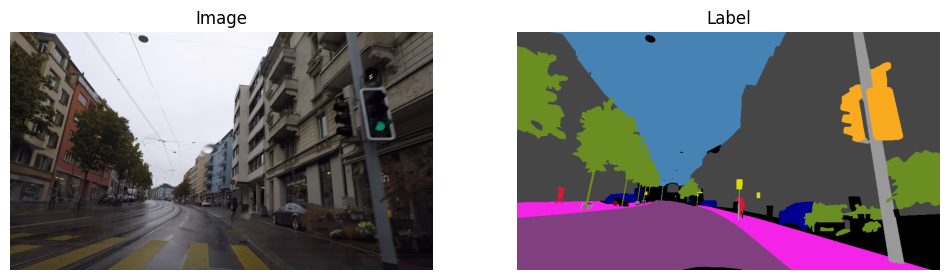

In [30]:
# Load the image and its corresponding label
image = unnormalize(images)[0].permute(1, 2, 0).numpy()
label = colored_label = ACDCDataset.decode_target(labels[0])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the image
axes[0].imshow(image)
axes[0].set_title('Image')
axes[0].axis('off')

# Display the label
axes[1].imshow(label)
axes[1].set_title('Label')
axes[1].axis('off')

plt.show()

In [42]:
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: %s" % device)

random_seed = 42 

# Setup random seed
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Create the dataset
dataset = ACDCDataset(
    root_dir='../../data',
    split='train',
    weather=['rain'],
    transform=image_transform,
    target_transform=label_transform
)

# Create the DataLoader
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

Device: cuda


In [43]:
model = network.modeling.__dict__[MODEL_NAME](num_classes=NUM_CLASSES, output_stride=OUTPUT_STRIDE)
model.load_state_dict(torch.load('weights/best_deeplabv3plus_resnet101_cityscapes_os16.pth.tar')['model_state'])
model.to('cuda')

utils.set_bn_momentum(model.backbone, momentum=0.01)

/tmp/ipykernel_149920/3424173523.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/best_deeplabv3plus_resnet101_cityscapes_os16.p

In [44]:
lr = 0.0001
weight_decay = 1e-4
total_itrs = 100

# Set up optimizer
optimizer = torch.optim.SGD(params=[
    {'params': model.backbone.parameters(), 'lr': 0.1 * lr},
    {'params': model.classifier.parameters(), 'lr': lr},
], lr=lr, momentum=0.9, weight_decay=weight_decay)

scheduler = utils.PolyLR(optimizer, total_itrs, power=0.9)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction='mean')

In [45]:
interval_loss = 0
best_score = 0.0
cur_itrs = 0
cur_epochs = 0
while True:  # cur_itrs < opts.total_itrs:
    # =====  Train  =====
    model.train()
    cur_epochs += 1
    for (images, labels) in train_loader:
        cur_itrs += 1

        images = images.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        np_loss = loss.detach().cpu().numpy()
        interval_loss += np_loss

        if (cur_itrs) % 10 == 0:
            interval_loss = interval_loss / 10
            print("Epoch %d, Itrs %d/%d, Loss=%f" %
                    (cur_epochs, cur_itrs, total_itrs, interval_loss))
            interval_loss = 0.0

        scheduler.step()

        if cur_itrs >= total_itrs:
            break

Epoch 1, Itrs 10/100, Loss=1.660184
Epoch 1, Itrs 20/100, Loss=1.158105


KeyboardInterrupt: 